# Análise de Contexto

Nessa etapa foi proposta análise de contexto dos tweets que teve por objetivo verificar o contexto dos tweets de determinado parlamentar tentando identificar a presença de discursos de ódio, e se identificados averiguar qual teor e a relação desses discursos com o parlamentar.

Combinando `Word2Vec` e `PCA` é possível a visualização de palavras e termos em espaço bidimensional e sua proximidade com outros termos.

Também foi feita análise de n-grams (uni, bi e tri-grams) utilizando a técnica de bag of words `BOW` e `CountVectorizer` e apresentados gráficos dos termos mais frequentes.

Foram utilizados os dados classificados após o ajuste fino.

# 1.Importando bibliotecas e dataset

In [1]:
# Imports da biblioteca padrão
import re
import string

# Imports de terceiros
import emoji
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from gensim.models import Word2Vec
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

# Imports específicos da aplicação/local
import pt_core_news_lg

# Configuração de estilos para gráficos
plt.style.use('ggplot')
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [2]:
# Dataset Erika Hilton
df_erika = pd.read_csv(
    'data/tweets_erika_modelo_ajustado.csv'
)

In [3]:
# Dataset de outros candidatos
df_candidatos = pd.read_parquet(
    'data/sp_elected_est_fed_dep_tweets-analysis.parquet', 
    engine = 'pyarrow'
)

## Criando funções

In [4]:
def remove_emoji_url(text):
    """
    Remove emojis e URLs de um texto.

    Args:
        texto (str): O texto do qual os emojis e URLs serão removidos.

    Returns:
        str: texto sem emojis e URLs.

    Esta função recebe um texto como entrada e utiliza expressões regulares 
    para remover emojis e URLs do texto, retornando o texto limpo.

    """
    # Regex para identificar padrões de emoji
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)

    # Regex para identificar padrões de URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    # Remove emojis e URLs
    texto_limpo = emoji_pattern.sub('', text)
    texto_limpo = url_pattern.sub('', texto_limpo)

    return texto_limpo

In [5]:

def limpar_tweet(text):
    """
    Limpa e pré-processa um tweet, removendo emojis, URLs, 
    stopwords e caracteres especiais.

    Args:
        texto (str): O texto do tweet a ser processado.

    Returns:
        list: Uma lista de tokens limpos após o pré-processamento.

    Esta função recebe um texto de tweet como entrada e realiza as 
    seguintes etapas de pré-processamento:
    1. Remove emojis e URLs do texto.
    2. Aplica um pipeline de processamento de linguagem natural 
    (NLP) ao texto.
    3. Cria uma lista customizada de stopwords, incluindo palavras 
    como "não", "nunca" e "jamais".
    4. Utiliza expressões regulares para identificar e remover caracteres 
    especiais, como parênteses e hífens.
    5. Realiza a lematização dos tokens, removendo pontuações, números, 
    dígitos e stopwords.
    6. Retorna a lista de tokens limpos resultante.

    """
    # Remove emojis e URLs
    texto_limpo = remove_emoji_url(text)

    # Aplicando pipeline de NLP
    doc = nlp(texto_limpo)

    # Criando lista customizada de stopwords mantidas
    custom_stopwords = ['não', 'nunca', 'jamais']

    # Regex para identificar padrões de caracteres 
    # especiais ('(', ')', '-')
    caracter_especial = r'[\(\)\-]'

    # Lemmatizar tokens, remover pontuações, numeros, 
    # digitos, stopwords e caracteres especiais
    tokens_limpos = [
        re.sub(caracter_especial, '', 
               token.lemma_.lower().strip()) 
        for token in doc if not token.is_punct 
        and not token.like_num and 
        (token.text.lower() in custom_stopwords 
         or not token.is_stop)
    ]

    return tokens_limpos

In [6]:
def histograma_tweets(df: pd.DataFrame, titulo:str):
    """
    Cria um histograma de tweets com informações estatísticas.

    Args:
        df (pd.DataFrame): Um DataFrame contendo os dados dos tweets.
        titulo (str): Título do histograma.

    Esta função cria um histograma para visualizar a distribuição dos 
    scores de ajuste fino de tweets. O histograma inclui informações 
    estatísticas, como título, rótulos dos eixos e uma formatação de 
    porcentagem no eixo y. Além disso, exibe estatísticas descritivas 
    dos scores.

    """
    
    plt.figure(figsize=(7,4))
    ax = sns.histplot(df, 
                    x = 'score_ajuste_fino', 
                    stat = 'percent', bins = 50, 
                    color = 'indianred')
    ax.set_title(titulo, fontsize=20, x=0.346, 
                 y=1.2, color="#696969")
    ax.spines['bottom'].set_color('#696969')  
    ax.spines['left'].set_color('#696969')  
    ax.tick_params(axis='x', colors='#696969')  
    ax.tick_params(axis='y', colors='#696969')
    ax.set_ylabel("Porcentagem", fontsize=11, 
                loc="top", color="#696969")
    ax.set_xlabel("Score classificador pós ajuste fino", 
                fontsize=11, loc="left", color="#696969")
    ax.yaxis.set_major_formatter(
        mticker.PercentFormatter(decimals=0)
    )

    plt.show()

    display(df['score_ajuste_fino'].describe().to_frame().T)

In [7]:
def termos_similares(modelo_w2v: Word2Vec, termo: str, aprox: int):
    """
    Encontra termos similares em um modelo Word2Vec.

    Args:
        modelo_w2v (Word2Vec): Um modelo Word2Vec treinado.
        termo (str): O termo para o qual se deseja encontrar termos similares.
        aprox (int): O número de casas decimais para arredondar os scores.

    Returns:
        pandas.DataFrame: Um DataFrame contendo termos similares e seus scores.
    """
    vetores = modelo_w2v.wv.most_similar(termo)
    df_termos = pd.DataFrame(
        [{'termos': termo[0], 'score': round(termo[1], aprox)} 
         for termo in vetores]
    )
    return df_termos

In [8]:
def analise_contexto(modelo_w2v: Word2Vec, palavras: list, 
                     nome: str, x_title: float, comentario: str, 
                     x_text: float, x_lim=None, y_lim=None):
    """
    Realiza análise de contexto de palavras usando PCA e exibe um gráfico de dispersão.

    Args:
        modelo_w2v (Word2Vec): Um modelo Word2Vec treinado.
        palavras (list): lista de palavras de interesse para serem analisadas
        nome (str): Nome ou descrição do contexto.
        x_title (float): Posição do título no eixo x.
        comentario (str): Comentário ou subtítulo a ser exibido no gráfico.
        x_text (float): Posição do comentário no eixo x.
        x_lim (tuple, opcional): Limites do eixo x. Padrão é None.
        y_lim (tuple, opcional): Limites do eixo y. Padrão é None.

    Retorna:
        None

    Esta função utiliza um modelo Word2Vec treinado para realizar uma análise de contexto de 
    palavras, aplicando a técnica de Análise de Componentes Principais (PCA) e exibe um gráfico 
    de dispersão. Ela permite visualizar a relação entre palavras em um espaço de alta 
    dimensionalidade e apresenta informações importantes, como título, comentário e limites dos 
    eixos. O gráfico é exibido, mas a função não retorna nenhum valor.
    """
    # Obtendo vetores das palavras
    palavra_vec = [modelo_w2v.wv.get_vector(i) for i in palavras]

    # Padronizando os dados (subtrai média e divide pelo desvio padrão)
    vec_scaler = StandardScaler().fit_transform(palavra_vec)

    # Instanciando PCA
    pca = PCA(n_components=2)

    # Fitando PCA
    palavras_pca = pca.fit_transform(vec_scaler)

    # Criando listas com valores do eixo x e y
    eixo_x = []
    eixo_y = []
    for i in palavras_pca:
        eixo_x.append(i[0])
        eixo_y.append(i[1])

    plt.figure(figsize=(8, 5))
    fig, ax = plt.subplots(figsize=(8,5))
    ax.scatter(eixo_x, eixo_y, color = 'indianred')
    ax.set_title(f'Contexto dos Tweets {nome}', 
                fontsize=20, x=x_title, y=1.2, color="#696969")
    ax.spines['bottom'].set_color('#696969')  
    ax.spines['left'].set_color('#696969')  
    ax.tick_params(axis='x', colors='#696969')  
    ax.tick_params(axis='y', colors='#696969')
    ax.set_ylabel("PCA 1", fontsize=11, 
                loc="top", color="#696969")
    ax.set_xlabel("PCA 2", fontsize=11, 
                loc="left", color="#696969")
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
    for i, txt in enumerate(palavras):
        ax.annotate(txt, (eixo_x[i], eixo_y[i]))

    # Comentário
    ax.text(x_text, 1.12, comentario, transform=ax.transAxes, 
            fontsize=10, ha='center', color='#696969')

    plt.show()

In [9]:
def nome_colunas(df: pd.DataFrame, tokenizer=CountVectorizer):
    """
    Atribui rótulos de coluna apropriados a um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame para o qual os rótulos de coluna serão atribuídos.
        tokenizer (type, opcional): O tokenizador usado para atribuir os rótulos. 
            Padrão é CountVectorizer.

    Returns:
        pd.DataFrame: O DataFrame com rótulos de coluna apropriados.
    """
    # Extrai rótulos dos tokens
    vocabulario = {v: k for k, v in tokenizer.vocabulary_.items()}
    
    # Atribui rótulos dos tokens às colunas apropriadas
    df.columns = df.columns.map(vocabulario)
    
    return df

In [10]:
def df_ngram(df: pd.DataFrame, col: str, tokenizer=CountVectorizer):
    """
    Cria uma representação de n-gram de um DataFrame a partir de uma coluna específica.

    Args:
        df (pd.DataFrame): O DataFrame a partir do qual a representação de n-gram será criada.
        col (str): O nome da coluna que contém os dados para a representação de n-gram.
        tokenizer (type, opcional): O tokenizador usado para criar a representação de n-gram.
            Padrão é CountVectorizer.

    Returns:
        pd.DataFrame: Um DataFrame contendo a representação de n-gram dos dados.
    """
    tokenizer_ngram = tokenizer
    bow_ngram = tokenizer_ngram.fit_transform(df[col])
    df_bow_ngram = pd.DataFrame(bow_ngram.todense())
    
    return df_bow_ngram

In [11]:
def frequencia_termos(df: pd.DataFrame, inicio:int, titulo:str, 
                      x_title:float, comentario:str, x_text:float):
        """
        Gera um gráfico de barras com a frequência de termos em um DataFrame.

        Args:
            df (pd.DataFrame): O DataFrame contendo os dados a serem analisados.
            inicio (int): O índice inicial para exibição dos termos mais frequentes.
            titulo (str): Título do gráfico.
            x_title (float): Posição do título no eixo x.
            comentario (str): Comentário ou subtítulo a ser exibido no gráfico.
            x_text (float): Posição do comentário no eixo x.

        Returns:
            None

        Esta função gera um gráfico de barras para visualizar a frequência dos termos 
        em um DataFrame. Os termos mais frequentes são exibidos a partir do índice 
        especificado. O gráfico inclui título, comentário e permite personalização da 
        aparência. O gráfico é exibido, mas a função não retorna nenhum valor específico.
        """
        
        df_ngram = (df.sum().sort_values(ascending=False)
                    .head(21).to_frame().reset_index())
        df_ngram.columns = ['termo', 'frequencia']

        plt.figure(figsize = (10, 6))
        ax = sns.barplot(df_ngram[inicio:], x = 'frequencia', 
                        y = 'termo', color = 'indianred')
        ax.set_title(titulo, fontsize=20, x=x_title, 
                     y=1.12, color="#696969")
        ax.spines['bottom'].set_color('#696969')
        ax.spines['left'].set_alpha(0)
        ax.tick_params(axis='x', colors='#696969', labelsize = 10)
        ax.tick_params(axis='y', colors='#696969', labelsize = 11)
        ax.set_ylabel("", fontsize=12, loc="top", color="#696969")
        ax.set_xlabel("Frequencia", fontsize=12, 
                loc="left", color="#696969")
        ax.yaxis.set_ticks_position('none')
                
        ax.text(x_text, 1.06, comentario, transform=ax.transAxes, 
                fontsize=11, ha='center', color='#696969')

        plt.show()

# 2.Investigando os dados

In [12]:
# Selecionando informações dos candidatos Carteiro Reaça e Marco Feliciano
df_carteiro = df_candidatos[
    df_candidatos['conversation_user'] == 'carteiroreaca'][
    ['content', 'class_label', 'class_score']
]
                                                                                                                            
df_carteiro.columns = ['tweets', 
                       'classe_ajuste_fino', 
                       'score_ajuste_fino']

df_feliciano = df_candidatos[
    df_candidatos['conversation_user'] == 'marcofeliciano'][
    ['content', 'class_label', 'class_score']
]
df_feliciano.columns = ['tweets',
                        'classe_ajuste_fino', 
                        'score_ajuste_fino']

In [13]:
# Contagem de classificação - Erika Hilton
df_erika['classe_ajuste_fino'].value_counts()

classe_ajuste_fino
False    20064
True      2441
Name: count, dtype: int64

In [14]:
df_erika['classe_ajuste_fino'].value_counts().sum()

22505

In [15]:
# Porcentagem de tweets ofensivos erika
erika_contagem = df_erika['classe_ajuste_fino'].value_counts()
porcent_ofensivos_erika = round(
    (erika_contagem[1] * 100) / erika_contagem.sum(), 2
)
porcent_ofensivos_erika

10.85

In [16]:
# Contagem de classificação - Carteiro Reaça
df_carteiro['classe_ajuste_fino'].value_counts()

classe_ajuste_fino
False    15857
True      3545
Name: count, dtype: int64

In [17]:
# Porcentagem de tweets ofensivos Carteiro Reaça                                                           
carteiro_contagem = df_carteiro['classe_ajuste_fino'].value_counts()
porcent_ofensivos_carteiro = round(
    (carteiro_contagem[1] * 100) / carteiro_contagem.sum(), 2
)
porcent_ofensivos_carteiro

18.27

In [18]:
# Contagem de classificação - Marco Feliciano
df_feliciano['classe_ajuste_fino'].value_counts()

classe_ajuste_fino
False    5364
True     1360
Name: count, dtype: int64

In [19]:
# Porcentagem de tweets ofensivos Marco Feliciano
feliciano_contagem = df_feliciano['classe_ajuste_fino'].value_counts()
porcent_ofensivos_feliciano = round(
    (feliciano_contagem[1] * 100) / feliciano_contagem.sum(), 2
)
porcent_ofensivos_feliciano

20.23

# 3.Pré-Processamento

In [20]:
# Instanciando Spacy
nlp = spacy.load("pt_core_news_lg")

In [21]:
# Aplicando função de limpeza nos tweets e criando 
# coluna com lista de tokens limpos
df_erika['tweets_limpos'] = \
    df_erika['tweets'].apply(limpar_tweet)

df_carteiro['tweets_limpos'] = \
    df_carteiro['tweets'].apply(limpar_tweet)

df_feliciano['tweets_limpos'] = \
    df_feliciano['tweets'].apply(limpar_tweet)

In [22]:
# Criando coluna com texto a partir da lista de tokens limpos 
df_erika['texto_limpo'] = \
    df_erika['tweets_limpos'].apply(
        lambda tokens: " ".join(tokens)
    )

df_carteiro['texto_limpo'] = \
    df_carteiro['tweets_limpos'].apply(
        lambda tokens: " ".join(tokens)
    )

df_feliciano['texto_limpo'] = \
    df_feliciano['tweets_limpos'].apply(
        lambda tokens: " ".join(tokens)
    )

In [23]:
# # Salvando dataframe. Possível utilizar esse dataframe 
# # sem precisar fazer tratamento anterior
# df_erika.to_csv(
#     'data/tweets_erika_modelo_ajustado_tratado.csv', 
#     index_label=False
# )
# df_carteiro.to_csv(
#     'data/tweets_carteiro_modelo_ajustado_tratado.csv', 
#     index_label=False
# )
# df_feliciano.to_csv(
#     'data/tweets_feliciano_modelo_ajustado_tratado.csv', 
#     index_label=False
# )

In [24]:
#Visualizando dataframe
df_erika.head()

,tweets,classe_ajuste_fino,score_ajuste_fino,tweets_limpos,texto_limpo
0,"Ao longo do dia estou recebendo denúncias, inc...",False,0.988363,"[longo, dia, receber, denúncia, pessoa, presas...",longo dia receber denúncia pessoa presas haver...
1,@ErikakHilton Simplesmente a maior ❤️❤️❤️ http...,False,0.997873,"[@erikakhilton, simplesmente, ]",@erikakhilton simplesmente
2,@PalasAthenas18 Hahahhaha 💜💜💜,False,0.955207,"[@palasathenas18, hahahhaha]",@palasathenas18 hahahhaha
3,"Ao longo do dia estou recebendo denúncias, inc...",False,0.988363,"[longo, dia, receber, denúncia, pessoa, presas...",longo dia receber denúncia pessoa presas haver...
4,@ErikakHilton É isso aí...,False,0.964833,[@erikakhilton],@erikakhilton


In [25]:
# Criando dataframe com tweets ofensivos
df_ofensiv_erika = df_erika[
    df_erika['classe_ajuste_fino'] == True
]

df_ofensiv_carteiro = df_carteiro[
    df_carteiro['classe_ajuste_fino'] == True
]

df_ofensiv_feliciano = df_feliciano[
    df_feliciano['classe_ajuste_fino'] == True
]

## Histograma e analise descritiva do score dos tweets ofensivos

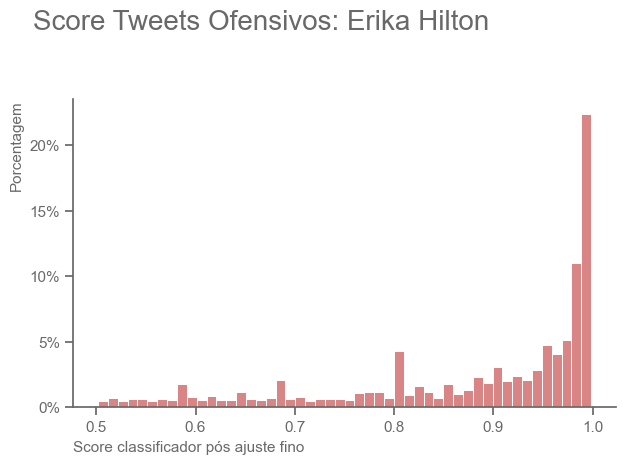

,count,mean,std,min,25%,50%,75%,max
score_ajuste_fino,2441.0,0.876816,0.136975,0.501753,0.802326,0.939163,0.986528,0.998632


In [26]:
histograma_tweets(df=df_ofensiv_erika, 
                  titulo='Score Tweets Ofensivos: Erika Hilton')

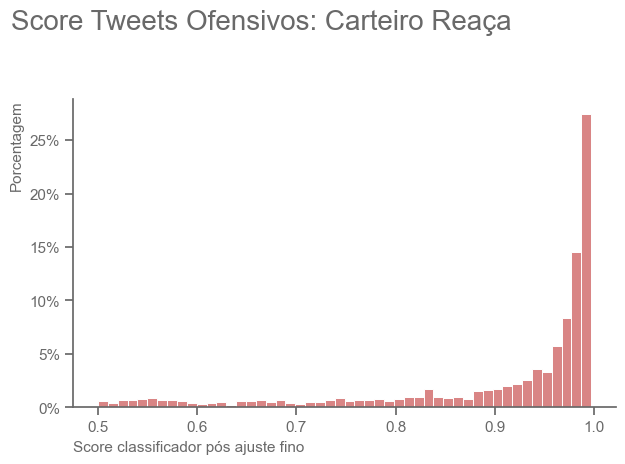

,count,mean,std,min,25%,50%,75%,max
score_ajuste_fino,3545.0,0.902623,0.12953,0.500313,0.869539,0.967709,0.987961,0.996905


In [27]:
histograma_tweets(df=df_ofensiv_carteiro, 
                  titulo='Score Tweets Ofensivos: Carteiro Reaça')

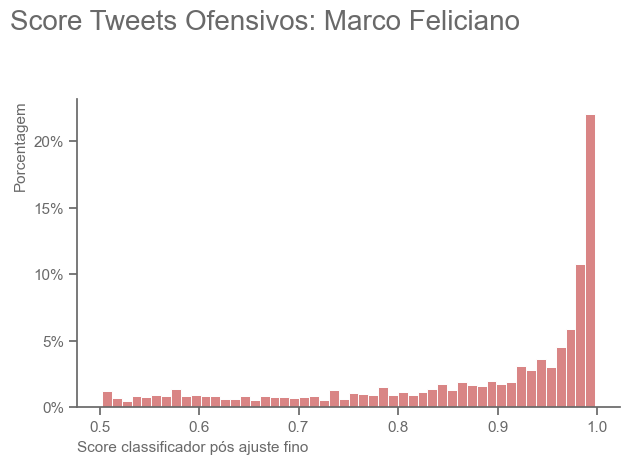

,count,mean,std,min,25%,50%,75%,max
score_ajuste_fino,1360.0,0.8728,0.142886,0.502374,0.794113,0.938099,0.986076,0.998144


In [28]:
histograma_tweets(df=df_ofensiv_feliciano, 
                  titulo='Score Tweets Ofensivos: Marco Feliciano')

Após essa analise inicial foi decidido prosseguir a análise de contexto e demais análises utilizando os tweets da candidata Erika Hilton. Essa decisão teve como base o perfil da parlamentar, pors e tratar de uma mulher trans, de origem periférica e com orientação política de esquerda. Dessa forma a hipótese inicial é de que ela sofreria ataques e ofensas devido seu perfil. 

# 4.Análise de contexto Erika Hilton

## Todos os tweets

### Word2Vec

In [29]:
#Instanciando Word2Vec para todos os tweets
erika = df_erika['tweets_limpos']

w2v_erika = Word2Vec(sentences = erika,   # Passando listas de tokens limpos
                     min_count=5,         # Mínimo de ocorrências para considerar a palavra
                     vector_size=400,     # Dimensão final do embedding 
                     window=5,            # Janela de contexto 
                     seed = 42)           # Definindo fator Pseudo aleatório

In [30]:
#Visualizando os 20 primeiros valores do vetor 
# de "@erikakhilton" para todos os tweets
print(w2v_erika.wv.get_vector('erika').shape)
w2v_erika.wv.get_vector('erika')[:20]

(400,)


array([ 0.03677415,  0.19931161, -0.31814525, -0.42854482, -0.02451152,
       -0.6857997 , -0.05721676,  0.02426353,  0.02088974, -0.3657581 ,
       -0.1977432 , -0.0780004 ,  0.12555884, -0.01786741, -0.13727364,
        0.03545626,  0.11812124,  0.04419277, -0.14564967,  0.04505737],
      dtype=float32)

### Similaridade de termos

In [31]:
termos_similares(w2v_erika, 'erika', 4)

,termos,score
0,deputada,0.9928
1,orgulho,0.9923
2,eleita,0.9917
3,tar,0.9899
4,feliz,0.9861
5,lindo,0.9843
6,mulher,0.9841
7,q,0.9823
8,tô,0.9802
9,amor,0.9758


In [32]:
termos_similares(w2v_erika, '@erikakhilton', 4)

,termos,score
0,ampliar,0.9783
1,absoluto,0.9777
2,diferença,0.9743
3,b,0.9726
4,isentar,0.9720
5,vencer,0.9702
6,roda,0.9700
7,flow,0.9681
8,auxilio,0.9674
9,@ricardostuckert,0.9672


In [33]:
termos_similares(w2v_erika, 'bolsonaro', 4)

,termos,score
0,sonegadores,0.9927
1,odeia,0.9916
2,aposentados,0.9892
3,censurou,0.9868
4,inimigo,0.9860
5,mentir,0.9853
6,confisconaeducação,0.9839
7,mentiroso,0.9788
8,mentiu,0.9777
9,janones,0.9769


In [34]:
termos_similares(w2v_erika, '@jairbolsonaro', 4)

,termos,score
0,@uneoficial,0.9995
1,destruir,0.9990
2,dor,0.9990
3,ódio,0.9990
4,@maria_ontt,0.9990
5,contrário,0.9989
6,t,0.9989
7,erikaaaa,0.9988
8,y,0.9988
9,evento,0.9988


In [35]:
termos_similares(w2v_erika, 'lula', 4)

,termos,score
0,dl,0.9921
1,presidente,0.9916
2,show,0.9892
3,venceu,0.9884
4,luiz,0.9873
5,amanhã,0.9842
6,inácio,0.9805
7,debate,0.9791
8,silva,0.9783
9,ganhou,0.9741


In [36]:
termos_similares(w2v_erika, '@lulaoficial', 4)

,termos,score
0,ganhou,0.9714
1,amanhã,0.9710
2,show,0.9709
3,dl,0.9706
4,lulanoflow,0.9681
5,importa,0.9660
6,venceu,0.9653
7,presidente,0.9649
8,debate,0.9602
9,perdeu,0.9595


Pela similaridade de termos vemos que a parlamentar escolhida não apresenta termos negativos/pejorativos relacionados a ela. A hipótese inicial era de que características como sexualidade, cor/etnia, orientação sexual e orientação política pudessem produzir discursos de ódio direcionados a essas características. 

No caso da parlamentar em questão os termos com maior similaridade foram positivos. Porém pudemos identificar que os candidatos à presidencia foram relacionados a termos negativos e ofensivos.

Vamos investigar assim o contexto relacionado à essas pessoas.

### Contexto

In [37]:
# Definindo palavras, encontradas no corpus, que serão visualizadas
palavras = ['lula','bolsonaro','vergonha','crime',
            'mentira', 'democracia', 'corrupto']

<Figure size 800x500 with 0 Axes>

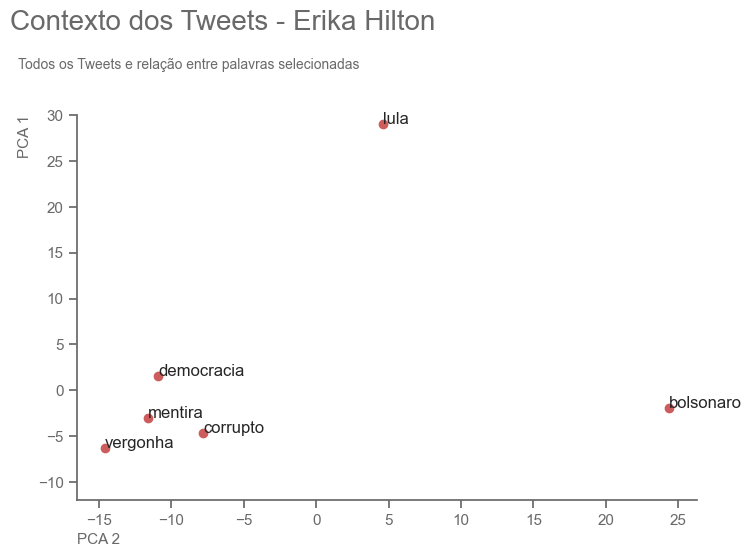

In [39]:
comentario = 'Todos os Tweets e relação entre palavras selecionadas'
analise_contexto(modelo_w2v=w2v_erika, palavras=palavras,
                 nome='- Erika Hilton', x_title=0.235, 
                 comentario=comentario, x_text=0.18,
                 y_lim=[-12,30])

A partir do gráfico observamos que analisando o corpus com todos os tweets os dois candidatos à presidencia estão posicionados de maneira similar aos outros termos. Isso pode indicar que não existe algum viés relacionando qualquer candidato à termos positivos ou prejorativos.

### Contagem de frequencia de unigrams com CountVectorizer

In [40]:
tokenizer_unigram_erika = CountVectorizer(ngram_range=(1, 1))
df_bow_unigram_erika = df_ngram(df=df_erika, col='texto_limpo', 
                                tokenizer=tokenizer_unigram_erika)

In [41]:
nome_colunas(df_bow_unigram_erika, tokenizer_unigram_erika).head()

,00,00h,02,03,05,08,10,100k,11h40,12,...,úrtima,úteis,útil,ķkkk,ŕeage,ᑫᵘᵉᵐ,ᵈᵉʳᵃ,ᵛᵉʳᵈᵃᵈᵉ,ᶠᵒˢˢᵉ,ℂℙ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


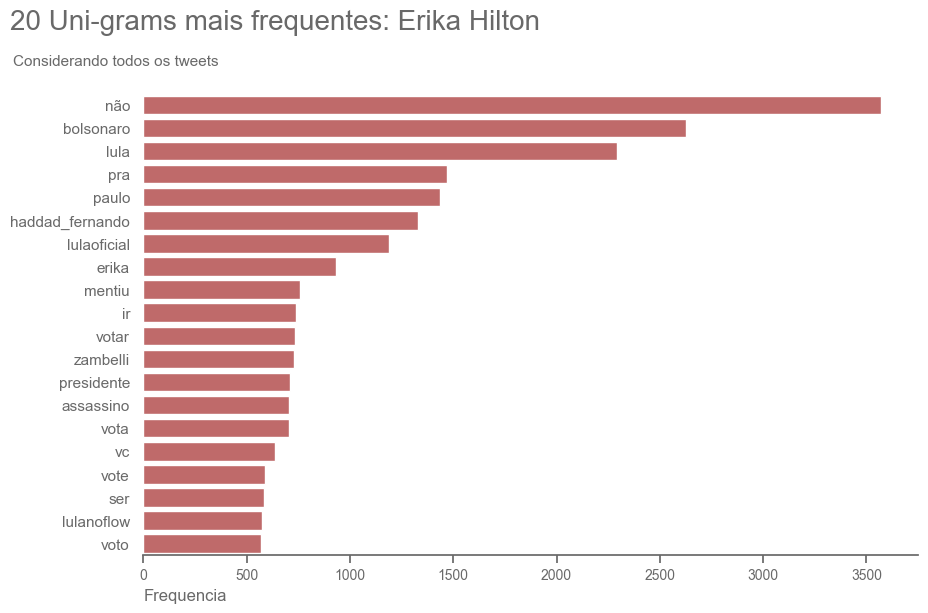

In [42]:
titulo = '20 Uni-grams mais frequentes: Erika Hilton'
comentario = 'Considerando todos os tweets'
frequencia_termos(df=df_bow_unigram_erika, inicio=1, x_title=0.17, 
                  titulo=titulo, comentario=comentario, x_text=-0.035)

Vamos executar a mesma análise utilizando somente os tweets classificados como ofensivos.

## Tweets ofensivos

### Word2Vec

In [43]:
#Instanciando Word2Vec para todos os tweets negativos
erika_ofensiv = df_ofensiv_erika['tweets_limpos']
w2v_erika_ofensivos = Word2Vec(sentences = erika_ofensiv,   # Passando listas de tokens limpos
                               min_count=5,                 # Mínimo de ocorrências para considerar a palavra
                               vector_size=400,             # Dimensão final do embedding 
                               window=5,                    # Janela de contexto 
                               seed = 42)                   # Definindo fator Pseudo aleatório
                            

In [44]:
#Visualizando os 20 primeiros valores do vetor da palavra "erika" para tweets ofensivos
print(w2v_erika_ofensivos.wv.get_vector('erika').shape)
w2v_erika_ofensivos.wv.get_vector('erika')[:20]

(400,)


array([ 0.0704729 , -0.09467364, -0.04265042,  0.2927188 ,  0.2074104 ,
       -0.04741389, -0.10092235,  0.12980542, -0.08116741, -0.12468766,
        0.06592917,  0.03703504,  0.08086922,  0.01028986, -0.09676815,
        0.00374291, -0.07488415, -0.21830116, -0.0077471 , -0.13522367],
      dtype=float32)

### Similaridade de termos

In [46]:
termos_similares(modelo_w2v=w2v_erika_ofensivos, 
                 termo='erika', aprox=4)

,termos,score
0,falar,0.9998
1,vc,0.9998
2,cara,0.9998
3,pra,0.9998
4,deixar,0.9998
5,vergonha,0.9997
6,governo,0.9997
7,bozo,0.9997
8,ficar,0.9997
9,dinheiro,0.9997


In [47]:
termos_similares(modelo_w2v=w2v_erika_ofensivos, 
                 termo='@erikakhilton', aprox=4)

,termos,score
0,nao,0.9859
1,tarcísio,0.9844
2,haddadnaglobo,0.9844
3,haddad,0.9832
4,miliciano,0.9827
5,ligar,0.9826
6,capacho,0.9819
7,felipe,0.9819
8,@jairbolsonaro,0.9819
9,ditadura,0.9815


In [48]:
termos_similares(modelo_w2v=w2v_erika_ofensivos, 
                 termo='bolsonaro', aprox=4)

,termos,score
0,mentiu,0.9924
1,sonegadores,0.9714
2,censurou,0.9547
3,novamente,0.9484
4,janones,0.9468
5,mente,0.9161
6,mg,0.8543
7,odeia,0.8533
8,,0.8399
9,pobre,0.8094


In [49]:
termos_similares(modelo_w2v=w2v_erika_ofensivos, 
                 termo='@jairbolsonaro', aprox=4)

,termos,score
0,deixar,0.9994
1,falar,0.9994
2,vc,0.9994
3,achar,0.9993
4,erika,0.9993
5,ver,0.9993
6,ficar,0.9993
7,miliciano,0.9993
8,passar,0.9993
9,votar,0.9993


In [50]:
termos_similares(modelo_w2v=w2v_erika_ofensivos, 
                 termo='lula', aprox=4)

,termos,score
0,inocente,0.9547
1,criminoso,0.9540
2,venceu,0.9462
3,dl,0.9368
4,show,0.9269
5,mg,0.9166
6,odeia,0.9140
7,pobre,0.9079
8,macetando,0.9073
9,sonegação,0.9054


In [51]:
termos_similares(modelo_w2v=w2v_erika_ofensivos, 
                 termo='@lulaoficial', aprox=4)

,termos,score
0,q,0.9998
1,ministra,0.9998
2,mentira,0.9998
3,ir,0.9998
4,usar,0.9998
5,vida,0.9998
6,hoje,0.9997
7,pessoa,0.9997
8,bandido,0.9997
9,denúncias,0.9997


Novamente a parlamentar tem similaridade maior com termos positivos ou neutros, enquanto os cadidatos à presidencia apresentam similaridade com muitos termos ofensivos.

### Contexto

<Figure size 800x500 with 0 Axes>

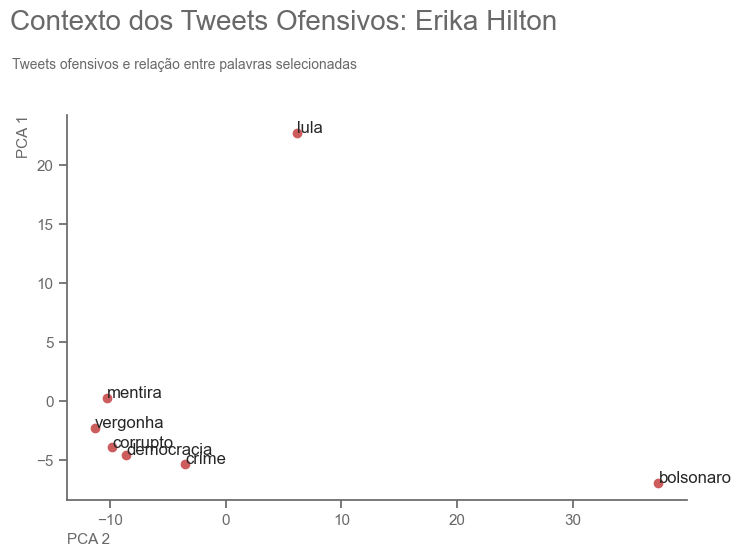

In [52]:
comentario = 'Tweets ofensivos e relação entre palavras selecionadas'
analise_contexto(modelo_w2v=w2v_erika_ofensivos, palavras=palavras, 
                 nome='Ofensivos: Erika Hilton', x_title=0.35,
                 comentario=comentario, x_text=0.19)

Ainda continuamos com a mesma disposiçaõ dos termos.

Porém ao observarmos o histograma com a classificação dos tweets ofensivos podemos ver que uma parte relevantes é classificada com pouxa certeza (estipulada entre 50 a 75%). Assim iremos filtrar os tweets com classificação acima de 75% mais adiante.

### Contagem de frequencia de unigrams com CountVectorizer

In [53]:
tokenizer_unigram_erika_ofensiv = CountVectorizer(ngram_range=(1, 1))
df_bow_unigram_erika_ofensiv = df_ngram(
    df=df_ofensiv_erika, col='texto_limpo', 
    tokenizer=tokenizer_unigram_erika_ofensiv
)

nome_colunas(df_bow_unigram_erika_ofensiv, 
             tokenizer_unigram_erika_ofensiv).head()

,00,10,12,13,13tolstoy13,18,1bilhao,1bilhaoemcorrupcao,20,21,...,érika,índio,índole,ódio,óleo,ótica,ônibus,ôrra,único,ķkkk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


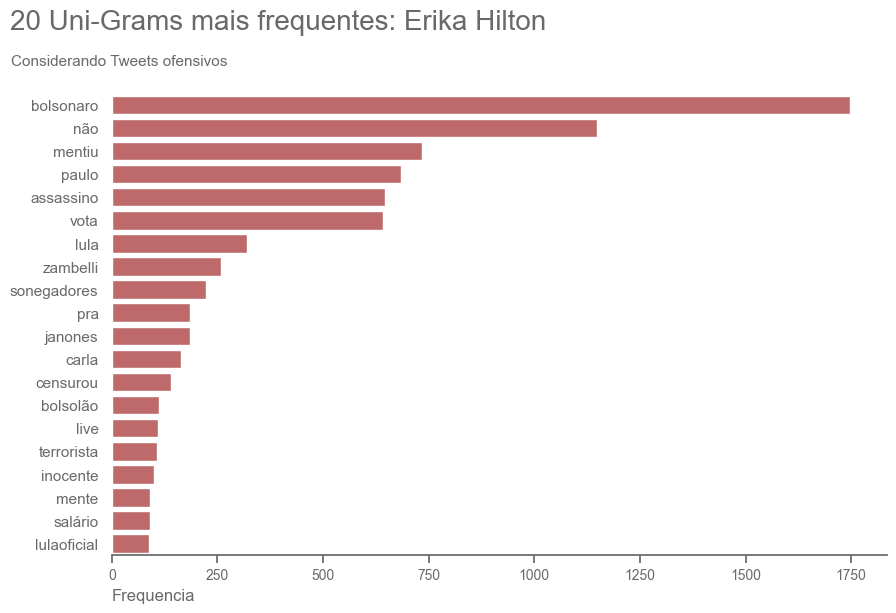

In [54]:
titulo = '20 Uni-Grams mais frequentes: Erika Hilton'
comentario = 'Considerando Tweets ofensivos'
frequencia_termos(df=df_bow_unigram_erika_ofensiv,
                  inicio=1, titulo=titulo, 
                  x_title=0.215, comentario=comentario,
                  x_text=0.01)

### Contagem de frequencia de bigrams com CountVectorizer

In [55]:
tokenizer_bigram_erika_ofensiv = CountVectorizer(ngram_range=(2, 2))
df_bow_bigram_erika_ofensiv = df_ngram(
    df=df_ofensiv_erika, col='texto_limpo', 
    tokenizer=tokenizer_bigram_erika_ofensiv
)

nome_colunas(df_bow_bigram_erika_ofensiv, 
             tokenizer_bigram_erika_ofensiv).head()

,00 hs,10 22,12 22,13 10,13tolstoy13 lula,18 00,1bilhao 1bilhaoemcorrupcao,1bilhaoemcorrupcao bolsoladrao,20 vacinar,21 lei,...,ótica bolsonarismo,ônibus lotar,ônibus normalmente,ônibus turno,ôrra reage,único amanhã,único coragem,único refeição,único rótulo,ķkkk quem
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


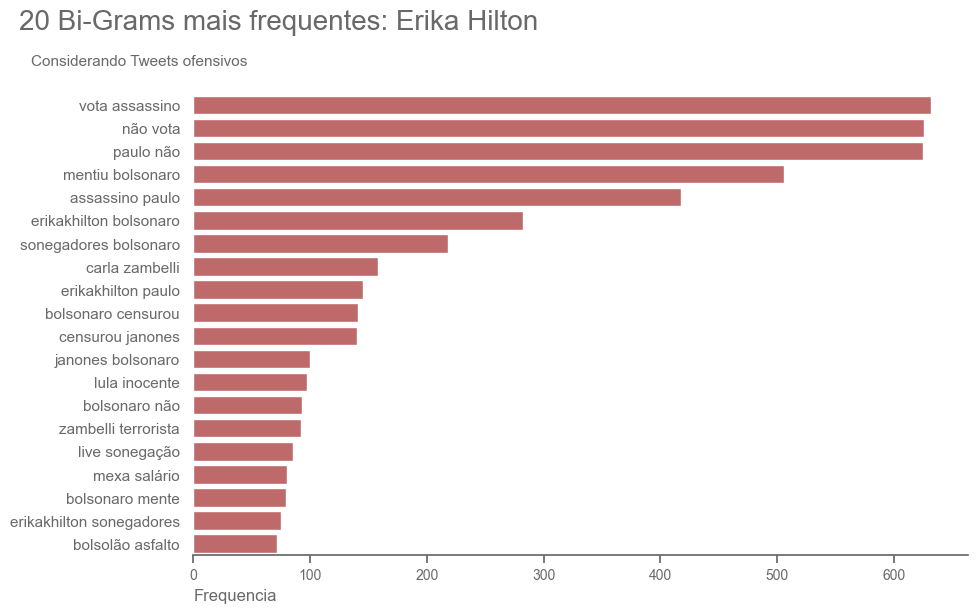

In [56]:
titulo = '20 Bi-Grams mais frequentes: Erika Hilton'
comentario = 'Considerando Tweets ofensivos'
frequencia_termos(df=df_bow_bigram_erika_ofensiv,
                  inicio=1, titulo=titulo, 
                  x_title=0.11, comentario=comentario,
                  x_text=-0.07)

### Contagem de frequencia de trigrams com CountVectorizer

In [57]:
tokenizer_trigram_erika_ofensiv = CountVectorizer(ngram_range=(3, 3))
df_bow_trigram_erika_ofensiv = df_ngram(
    df=df_ofensiv_erika, col='texto_limpo', 
    tokenizer=tokenizer_trigram_erika_ofensiv
)

nome_colunas(df_bow_trigram_erika_ofensiv, 
             tokenizer_trigram_erika_ofensiv).head()

,00 hs ser,10 22 arroaceiro,12 22 aprontar,13 10 22,13tolstoy13 lula venceu,18 00 hs,1bilhao 1bilhaoemcorrupcao bolsoladrao,20 vacinar jan,21 lei ladrao,22 aprontar muuuuuuuuuito,...,ótica bolsonarismo roberto,ônibus lotar metrô,ônibus normalmente passar,ônibus turno pelamor,ôrra reage paulo,único amanhã dia,único coragem missão,único refeição monstro,único rótulo caber,ķkkk quem lhe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


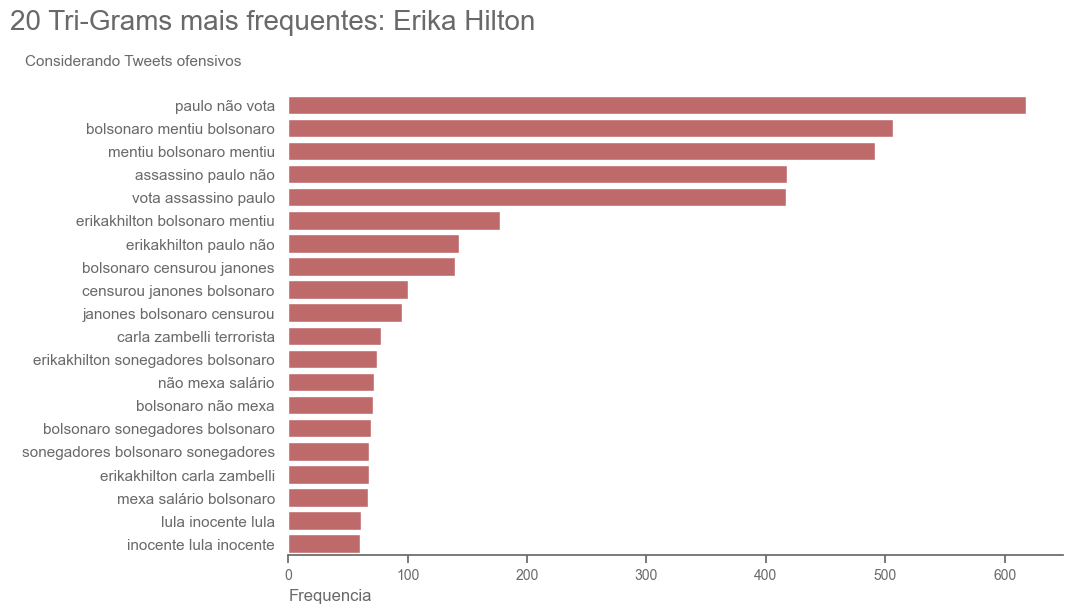

In [58]:
titulo = '20 Tri-Grams mais frequentes: Erika Hilton'
comentario = 'Considerando Tweets ofensivos'
frequencia_termos(df=df_bow_trigram_erika_ofensiv,
                  inicio=1, titulo=titulo, 
                  x_title=-0.02, comentario=comentario,
                  x_text=-0.2)

## Tweets ofensivos com score > 75%

### Word2Vec

In [59]:
# Selecionando tweets negativos com score acima de 75%
df_tweets_ofensivos_75_erika = df_ofensiv_erika[
    df_ofensiv_erika['score_ajuste_fino'] >= 0.75
]

In [60]:
#Teste com limpeza mais desenvolvida
#Instanciando Word2Vec para todos os tweets
erika_ofensiv_75 = df_tweets_ofensivos_75_erika['tweets_limpos']
w2v_erika_ofensivos_75 = Word2Vec(sentences = erika_ofensiv_75,   # Passando listas de tokens tratados
                                  min_count=5,                    # Mínimo de ocorrências para considerar a palavra
                                  vector_size=400,                # Dimensão final do embedding 
                                  window=5,                       # Janela de contexto 
                                  seed = 42)                      # Definindo fator Pseudo aleatório

In [61]:
#Visualizando os 20 primeiros valores do vetor da palavra 
# "erika" para tweets ofensivos com score acima de 75%
print(w2v_erika_ofensivos_75.wv.get_vector('erika').shape)
w2v_erika_ofensivos_75.wv.get_vector('erika')[:20]

(400,)


array([ 0.00831228,  0.12294967, -0.05230668,  0.08291236, -0.02262889,
        0.05092821,  0.09376381, -0.04060955,  0.07586019, -0.13905096,
        0.00555363, -0.03321251, -0.05661841,  0.13122348, -0.0395915 ,
        0.0292688 ,  0.03164374,  0.04513729,  0.15161036,  0.03490071],
      dtype=float32)

In [63]:
termos_similares(modelo_w2v= w2v_erika_ofensivos_75,
                 termo='erika', aprox=4)

,termos,score
0,cara,0.9998
1,falar,0.9998
2,sp,0.9997
3,haddad,0.9997
4,deixar,0.9997
5,achar,0.9997
6,eleger,0.9997
7,ficar,0.9996
8,pra,0.9996
9,nunca,0.9996


In [64]:
termos_similares(modelo_w2v= w2v_erika_ofensivos_75,
                 termo='@erikakhilton', aprox=4)

,termos,score
0,reage,0.9944
1,@haddad_fernando,0.9936
2,@rodrigogarcer,0.9930
3,tarcísio,0.9926
4,conseguir,0.9913
5,prefeito,0.9910
6,milícia,0.9908
7,feio,0.9908
8,haddad,0.9908
9,seguinte,0.9904


In [65]:
termos_similares(modelo_w2v=w2v_erika_ofensivos_75, 
                 termo='bolsonaro', aprox=4)

,termos,score
0,mentiu,0.9903
1,censurou,0.9692
2,janones,0.9487
3,novamente,0.9474
4,sonegadores,0.9399
5,mente,0.9118
6,mg,0.8183
7,,0.7821
8,sonegação,0.7800
9,odeia,0.7787


In [66]:
termos_similares(modelo_w2v=w2v_erika_ofensivos_75, 
                 termo='@jairbolsonaro', aprox=4)

,termos,score
0,pra,0.9997
1,homem,0.9996
2,brasil,0.9996
3,ano,0.9996
4,tar,0.9996
5,nunca,0.9996
6,bolsonarista,0.9996
7,coisa,0.9996
8,mentira,0.9996
9,deixar,0.9996


In [67]:
termos_similares(modelo_w2v=w2v_erika_ofensivos_75, 
                 termo='lula', aprox=4)

,termos,score
0,criminoso,0.9936
1,macetando,0.9760
2,live,0.9758
3,@andrejanonesadv,0.9738
4,pobre,0.9737
5,mentiroso,0.9730
6,peguem,0.9726
7,venceu,0.9720
8,odeia,0.9719
9,sonegação,0.9718


In [68]:
termos_similares(modelo_w2v=w2v_erika_ofensivos_75, 
                 termo='@lulaoficial', aprox=4)

,termos,score
0,ir,0.9997
1,ser,0.9997
2,ministra,0.9997
3,corrupção,0.9997
4,hoje,0.9997
5,perder,0.9997
6,dinheiro,0.9996
7,ladrão,0.9996
8,conferir,0.9996
9,bandido,0.9996


Novamente vemos o mesmo padrão.

### Contexto

<Figure size 800x500 with 0 Axes>

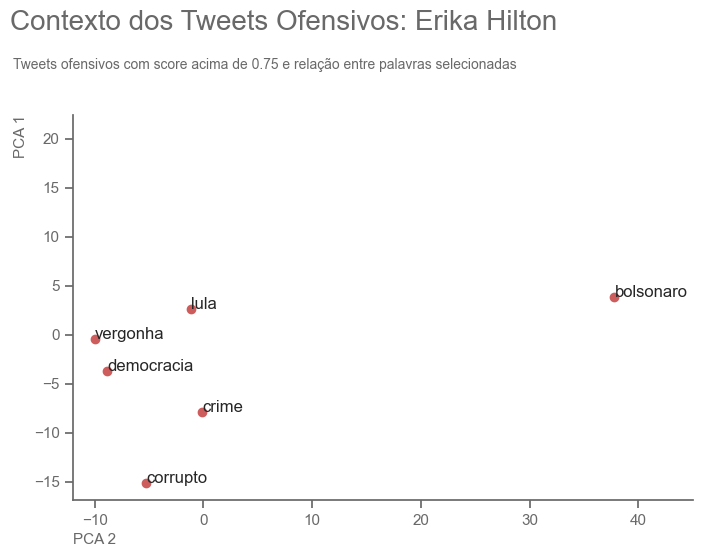

In [69]:
comentario = "Tweets ofensivos com score acima de 0.75 e relação entre palavras selecionadas"
analise_contexto(modelo_w2v=w2v_erika_ofensivos_75, palavras=palavras,
                 nome='Ofensivos: Erika Hilton', x_title=0.34,
                 comentario=comentario, x_text=0.31, 
                 x_lim=[-12, 45])

Ao filtrar os tweets ofensivos com classificação acima de 75% podemos ver uma mudança na disposição dos termos. 

O candidato "lula" se aproximou dos termos, que incluem termos majoritariamente negativos, enquanto o candidato "bolsonaro" permanece na mesma posição.

A partir dessa disposição podemos supor que os tweets ofensivos tiveram origem da oposição do candidato "lula", defendido pela aprlamentar Erika Hilton. Podemos supor então que o discurso de ódio atacando o candidato "lula" teve origem da base apoiadora do candidato "bolsonaro".

### Contagem de frequencia de unigrams com CountVectorizer

In [70]:
tokenizer_unigram_erika_ofensiv_75 = CountVectorizer(ngram_range=(1, 1))
df_bow_unigram_erika_ofensiv_75 = df_ngram(
    df=df_tweets_ofensivos_75_erika, col='texto_limpo', 
    tokenizer=tokenizer_unigram_erika_ofensiv_75
)

nome_colunas(df_bow_unigram_erika_ofensiv_75, 
             tokenizer_unigram_erika_ofensiv_75).head()

,00,10,12,13,13tolstoy13,18,1bilhao,1bilhaoemcorrupcao,20,21,...,álcool,árbole,época,érika,ódio,óleo,ônibus,ôrra,único,ķkkk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


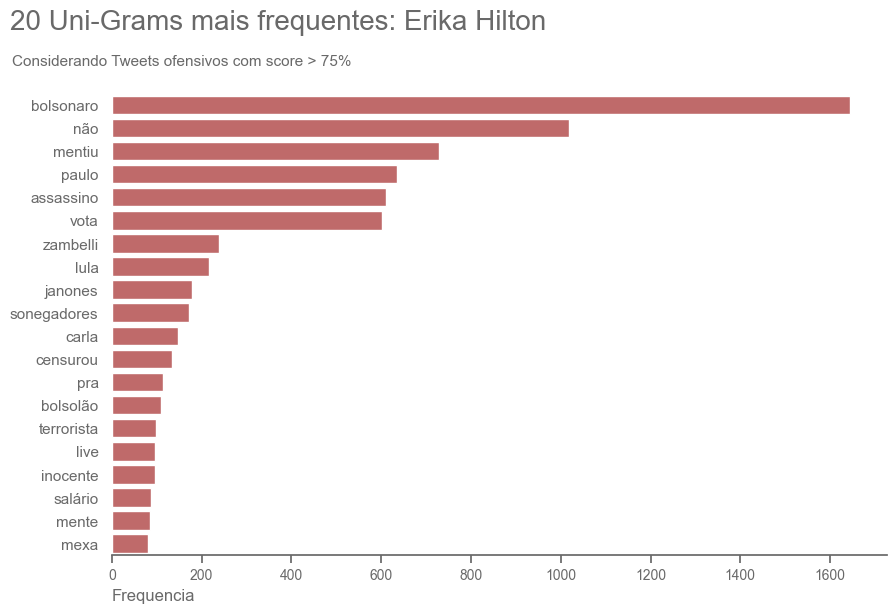

In [71]:
titulo = '20 Uni-Grams mais frequentes: Erika Hilton'
comentario = 'Considerando Tweets ofensivos com score > 75%'
frequencia_termos(df=df_bow_unigram_erika_ofensiv_75,
                  inicio=1, titulo=titulo, 
                  x_title=0.215, comentario=comentario,
                  x_text=0.09)

### Contagem de frequencia de bigrams com CountVectorizer

In [72]:
tokenizer_bigram_erika_ofensiv_75 = CountVectorizer(ngram_range=(2, 2))
df_bow_bigram_erika_ofensiv_75 = df_ngram(
    df=df_tweets_ofensivos_75_erika, col='texto_limpo', 
    tokenizer=tokenizer_bigram_erika_ofensiv_75
)

nome_colunas(df_bow_bigram_erika_ofensiv_75, 
             tokenizer_bigram_erika_ofensiv_75).head()

,00 hs,10 22,12 22,13 10,13tolstoy13 lula,18 00,1bilhao 1bilhaoemcorrupcao,1bilhaoemcorrupcao bolsoladrao,20 vacinar,21 lei,...,óleo peroba,ônibus lotar,ônibus normalmente,ônibus turno,ôrra reage,único amanhã,único coragem,único refeição,único rótulo,ķkkk quem
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


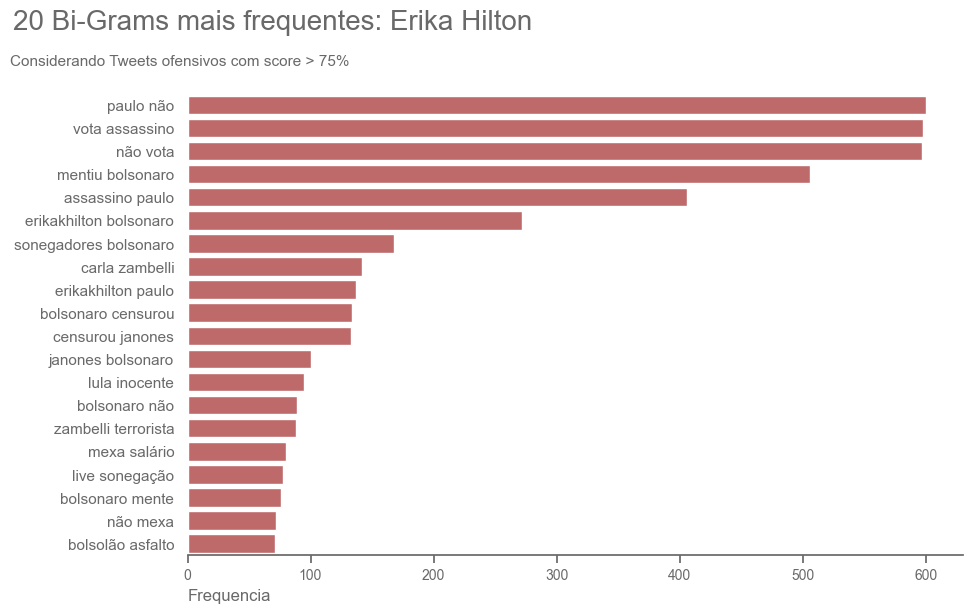

In [73]:
titulo = '20 Bi-Grams mais frequentes: Erika Hilton'
comentario = 'Considerando Tweets ofensivos com score > 75%'
frequencia_termos(df=df_bow_bigram_erika_ofensiv_75,
                  inicio=1, titulo=titulo, 
                  x_title=0.11, comentario=comentario,
                  x_text=-0.01)

### Contagem de frequencia de trigrams com CountVectorizer

In [74]:
tokenizer_trigram_erika_ofensiv_75 = CountVectorizer(ngram_range=(3, 3))
df_bow_trigram_erika_ofensiv_75 = df_ngram(
    df=df_tweets_ofensivos_75_erika, col='texto_limpo', 
    tokenizer=tokenizer_trigram_erika_ofensiv_75
)

nome_colunas(df_bow_trigram_erika_ofensiv_75, 
             tokenizer_trigram_erika_ofensiv_75).head()

,00 hs ser,10 22 arroaceiro,12 22 aprontar,13 10 22,13tolstoy13 lula venceu,18 00 hs,1bilhao 1bilhaoemcorrupcao bolsoladrao,20 vacinar jan,21 lei ladrao,22 aprontar muuuuuuuuuito,...,óleo peroba tá,ônibus lotar metrô,ônibus normalmente passar,ônibus turno pelamor,ôrra reage paulo,único amanhã dia,único coragem missão,único refeição monstro,único rótulo caber,ķkkk quem lhe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


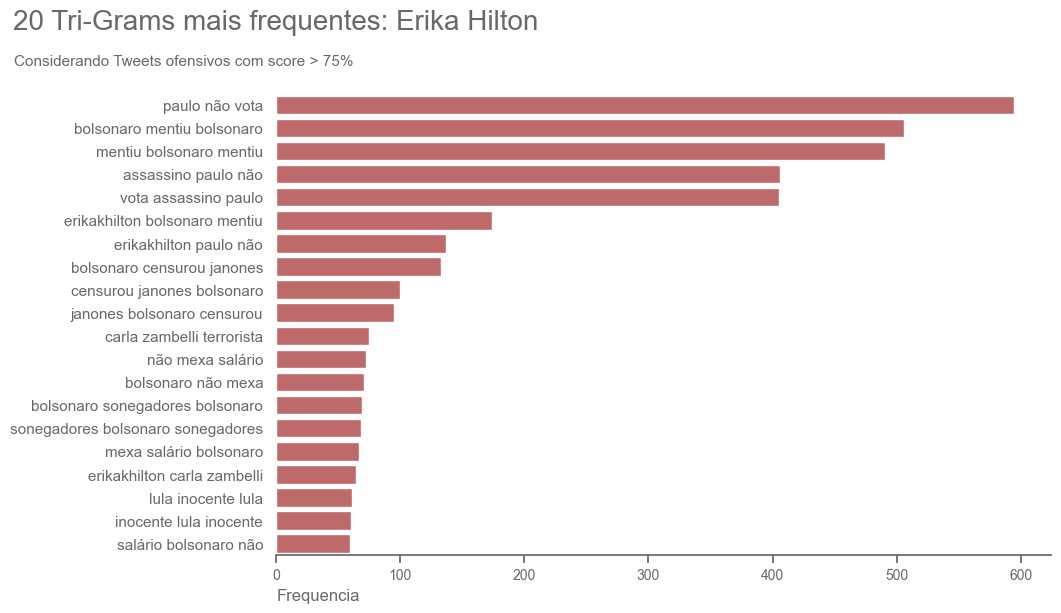

In [75]:
titulo = '20 Tri-Grams mais frequentes: Erika Hilton'
comentario = 'Considerando Tweets ofensivos com score > 75%'
frequencia_termos(df=df_bow_trigram_erika_ofensiv_75,
                  inicio=1, titulo=titulo, 
                  x_title=-0.001, comentario=comentario,
                  x_text=-0.12)

# 5.Conclusão

Utilizando técnicas de processamento de linguagem natural podemos extrair insights relevantes de textos e documentos.

Nesse caso não foi possível identificar discursos de ódio direcionados à parlamentar Erika Hilton, porém essas ofensas estavam direcionadas ao candidato apoiado pela parlamentar.

Essa abordagem é um passo importante para conseguirmos extair e analisar grande quantidade de textos e documentos para identificar possíveis fontes de discursos de ódio e assim tomar ações contra essas atitudes e possíveis crimes.